## Постановка задачи
У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который **для каждой пары пользователь-услуга определит вероятность подключения услуги**.

### Исходные данные

#### наборы данных
- **features.csv** (22Г): id, buy_time, <feature_list>
нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
- **data_train.csv** (27М): id, vas_id, buy_time, target
информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
- **data_test.csv**: id, vas_id, buy_time
тестовый набор

#### переменные
   - **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.
   - **buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
   - **id** - идентификатор абонента
   - **vas_id** - подключаемая услуга




### Анализ схемы данных

1. считаем data_train и data_test и проверим на разнообразие услуг и абонентов
2. Восстановим наборы абонентов и услуг
3. обработаем features.csv отфильруем только то что есть в data_train и data_test!

![Схема](data_schema.png)

In [28]:
import os.path

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Считаем исходные данные

In [158]:
data_train = pd.read_csv('data_train.csv')
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [159]:
data_test = pd.read_csv('data_test.csv')
data_test.head(3)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400


Объединим наборы для восстановления id абонентов

In [160]:
data_all = pd.concat([data_train.drop(columns='target'), data_test])
data_all.head(3)

,Unnamed: 0,id,vas_id,buy_time
0,0,540968,8.0,1537131600
1,1,1454121,4.0,1531688400
2,2,2458816,1.0,1534107600


In [27]:
data_all.shape[0], data_all.id.nunique(), data_all.vas_id.nunique()

(902884, 872577, 8)

> нам необходимо отфильтровать features.csv по 872 тыс абонентов

оценим количество строк в features.csv

In [ ]:
num_lines = 0
with open("features.csv") as f:
    for line in f:
        num_lines +=1
        if num_lines % 10000 == 0:
            print(num_lines, line[0:20])

>Всего в файле 4,5 млн запиисей

### Эксперимент над частью профиля

Создадим для экспериментов срез файла features.csv - первые 5 тыс. записей

In [38]:
num_lines = 5000
with open("features_lite.csv", "x") as lite:
    with open("features.csv") as f:
        for line in f:
            lite.write(line)
            num_lines -= 1
            if num_lines % 100 == 0:
                print(num_lines, line[0:20])
            if num_lines <= 0:
                break

4900 98	2402038	154559880
4800 198	2813843	15462036
4700 298	3554903	15328980
4600 398	3661489	15419700
4500 498	3748859	15310836
4400 598	3863771	15468084
4300 698	3963168	15322932
4200 798	4047744	15377364
4100 898	4129298	15310836
4000 998	4201230	15322932
3900 1098	4270438	1538946
3800 1198	4344118	1535922
3700 1298	50258	154257480
3600 1398	133220	15389460
3500 1498	216934	15310836
3400 1598	293264	15377364
3300 1698	366781	15455988
3200 1798	439178	15365268
3100 1898	568256	15425748
3000 1998	879298	15310836
2900 2098	923040	15449940
2800 2198	942906	15449940
2700 2298	961432	15462036
2600 2398	981936	15377364
2500 2498	1004744	1541365
2400 2598	1040382	1532293
2300 2698	1071139	1545598
2200 2798	1089994	1533502
2100 2898	1111412	1535317
2000 2998	1128739	1544994
1900 3098	1146979	1534107
1800 3198	1165797	1546203
1700 3298	1186322	1536526
1600 3398	1241864	1544389
1500 3498	1257553	1535317
1400 3598	1278188	1544389
1300 3698	1297428	1543784
1200 3798	1317219	1542574
1100 3898	13

In [40]:
features = pd.read_csv('features_lite.csv', sep="\t")
features.head(3)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [42]:
features.shape

(4999, 256)

#### Фильтрация по клиентам
Проведем фильтрацию features только по клиентам  data_all

In [55]:
merge = features.id.isin(data_all.id)
features1 = features[merge]
features1.head(5)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
13,13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
22,22,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [54]:
features1.id.value_counts().sum(), features.id.count()

(946, 4999)

> по предварительной выборке можно сократить набор features в 5 раз

#### Пропуски

In [57]:
print("ID уникален? ", features1.id.is_unique)
print("Есть ли дубли в строках?", features1.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float(
    (features1.isnull().sum() > 0).sum() / features1.shape[1] * 100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


#### Анализ типа переменных
Просмотрим визуально признаки  features

In [56]:
features1.head(10).T

,13,16,19,20,22,27,33,34,39,43
Unnamed: 0,1.300000e+01,1.600000e+01,1.900000e+01,2.000000e+01,2.200000e+01,2.700000e+01,3.300000e+01,3.400000e+01,3.900000e+01,4.300000e+01
id,2.046132e+06,2.050810e+06,2.070757e+06,2.071522e+06,2.075318e+06,2.085648e+06,2.102126e+06,2.104377e+06,2.133447e+06,2.212313e+06
buy_time,1.534712e+09,1.540760e+09,1.540760e+09,1.544994e+09,1.533503e+09,1.539551e+09,1.538341e+09,1.532293e+09,1.535317e+09,1.537736e+09
0,3.008200e+02,-8.620997e+01,-9.679997e+01,-9.493997e+01,-7.563997e+01,6.844003e+01,1.998100e+02,-9.679997e+01,3.544800e+02,-2.899997e+01
1,1.599481e+03,9.182089e+01,-4.081791e+02,-3.636991e+02,6.696909e+02,2.604309e+02,1.850109e+02,-4.081791e+02,5.370089e+01,-6.071911e+01
...,...,...,...,...,...,...,...,...,...,...
248,-1.783289e+01,-2.583289e+01,-2.483289e+01,-2.583289e+01,-1.483289e+01,-6.832889e+00,-8.832889e+00,3.216711e+01,-8.328886e-01,-2.483289e+01
249,-6.944285e-01,-6.944285e-01,3.055715e-01,-6.944285e-01,2.305572e+00,-6.944285e-01,-6.944285e-01,-6.944285e-01,-6.944285e-01,-6.944285e-01
250,-4.175933e+00,-1.217593e+01,-1.217593e+01,-1.217593e+01,-4.175933e+00,-5.175933e+00,4.824067e+00,4.582407e+01,1.282407e+01,-1.217593e+01
251,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,-4.561399e-01,5.438601e-01


Часть признаков имеют категориальный/бинарный характер: 6, 8, 9, 10, 11, 12... Поэтому можно провести более глубокий анализ

In [5]:
class FeaturesInspect:
    dataframe = None
    feat_nunique = None
    feats = dict()

    def __init__(self, dataframe, num_cat=10):
        self.dataframe = dataframe
        self.feat_nunique = self.dataframe.apply(lambda x: x.nunique(dropna=False))
        self.num_cat = num_cat

    def show_nunique(self):
        plt.title("Распределение уникальных значений признаков")
        self.feat_nunique.hist(bins=100, figsize=(10, 5))

    def collect(self):
        self.feats['all'] = set(self.feat_nunique.index.tolist())
        self._collect_const()
        self._collect_numeric()
        self.feats['other'] = self.feats['all'] - (self.feats['numeric'] | self.feats['const'])
        self._collect_binary()
        self._collect_categorical()
        self.feats['extra'] = self.feats['categorical']
        self.feats['ok'] = self.feats['binary'] | self.feats['categorical'] | self.feats['numeric']

    def print(self):
        print('Всего уникальных признаков :', len(self.feats['all']))
        print('...константные  признаки :', len(self.feats['const']))
        print('...вещественные признаки :', len(self.feats['numeric']))
        self.feats['other'] = self.feats['all'] - (self.feats['numeric'] | self.feats['const'])
        print('...другие признаки :', len(self.feats['other']))
        print('...бинарные признаки :', len(self.feats['binary']))
        print('...категориальные признаки :', len(self.feats['categorical']))
        self.feats['extra'] = self.feats['categorical']
        self.feats['ok'] = self.feats['binary'] | self.feats['categorical'] | self.feats['numeric']

    def _collect_const(self):
        self.feats['const'] = set(self.feat_nunique[self.feat_nunique == 1].index.tolist())
        return len(self.feats['const'])

    def _collect_numeric(self):
        f_numeric = (self.dataframe.fillna(0).astype(int).sum() - self.dataframe.fillna(0).sum()).abs()
        self.feats['numeric'] = set(f_numeric[f_numeric > 0].index.tolist())
        return len(self.feats['numeric'])

    def _collect_categorical(self):
        self.feats['categorical'] = set(
            self.feat_nunique.loc[self.feats['other']][
                self.feat_nunique.loc[self.feats['other']] <= self.num_cat].index.tolist())
        return len(self.feats['categorical'])

    def _collect_binary(self):
        f_other = self.feats['other']
        self.feats['binary'] = set(self.dataframe.loc[:, f_other].columns[(
                (self.dataframe.loc[:, f_other].max() == 1) &
                (self.dataframe.loc[:, f_other].min() == 0) &
                (self.dataframe.loc[:, f_other].isnull().sum() == 0))])
        return len(self.feats['binary'])


In [116]:
feat_inspector = FeaturesInspect(features, num_cat=10)
feat_inspector.feat_nunique.shape

(256,)

In [117]:
#feat_inspector.show_nunique()

In [118]:
feat_inspector.collect()
feat_inspector.print()

Всего уникальных признаков : 256
...константные  признаки : 13
...вещественные признаки : 247
...другие признаки : 4
...бинарные признаки : 1
...категориальные признаки : 1


### Обработка файла большого объема features

#### Чтение файла по частям

In [164]:
import pyarrow

создание итератора чтения файла по 100 тыс строк

In [172]:
df_big = pd.read_csv('features.csv', chunksize=100000, iterator=True, sep="\t")

#### Фильтрация и запись по частям

Фильтрация каждой части по списку абонентов и запись в отдельный файл в директории data

In [ ]:
iter=1
for dfb in df_big:
    # фильтрация по всем клиентам
    merge = dfb['id'].isin(data_all.id)
    dfb_filter = dfb[merge]
    file_name= 'data/features'+f"{iter:03d}.parquet"
    print(file_name)
    dfb_filter.to_parquet(file_name)
    iter +=1

#### Объединение всех частей

Чтение всей директории data преобразование в pandas и сохрание нового набора

In [ ]:
table = pyarrow.parquet.read_table('data')
df_new = table.to_pandas()
df_new.head(5)

In [182]:
df_new.shape

(902389, 256)

In [183]:
df_new.to_parquet('features_clients.parquet')

In [184]:
df_new.memory_usage().sum()

1855311784

> Набор занимает в памяти около 2Г

In [186]:
import os
os.path.getsize('features_clients.parquet')

202144348

>Файл занимает на диске около 200М

In [3]:
features_new=pd.read_parquet('features_clients.parquet')

### Преобразование переменных


In [6]:
feat_inspector = FeaturesInspect(features_new, num_cat=10)

In [7]:
feat_inspector.collect()
feat_inspector.print()

Всего уникальных признаков : 256
...константные  признаки : 5
...вещественные признаки : 247
...другие признаки : 4
...бинарные признаки : 0
...категориальные признаки : 0


In [8]:
feat_inspector.feats['const']

{'139', '203', '75', '81', '85'}

In [58]:
features_new[list(feat_inspector.feats['const'])].head()

KeyError: "None of [Index(['81', '85', '75', '139', '203'], dtype='object')] are in the [columns]"

#### Удаление константных признаков

In [21]:
features_new.drop(columns=list(feat_inspector.feats['const']),inplace=True)

In [22]:
features_new.to_parquet('features_drop.parquet')

In [53]:
features_new = pd.read_parquet('features_drop.parquet')

In [54]:
features_new.columns

Index(['Unnamed: 0', 'id', 'buy_time', '0', '1', '2', '3', '4', '5', '6',
       ...
       '243', '244', '245', '246', '247', '248', '249', '250', '251', '252'],
      dtype='object', length=251)

#### Удаление старого индекса

In [55]:
features_new.drop(columns=['Unnamed: 0'], inplace=True)

#### Установка нового индекса

In [56]:
features_new.set_index('id', inplace=True)

In [59]:
features_new.head(3)

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0


#### Преобразование даты

In [62]:
import datetime

In [64]:
datetime.datetime.fromtimestamp(1534712400)

datetime.datetime(2018, 8, 20, 0, 0)

In [61]:
features_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 2046132 to 3521152
Columns: 249 entries, buy_time to 252
dtypes: float64(248), int64(1)
memory usage: 1.7 GB


In [65]:
pd.to_datetime(features_new['buy_time'], unit='s')

id
2046132   2018-08-19 21:00:00
2050810   2018-10-28 21:00:00
2070757   2018-10-28 21:00:00
2071522   2018-12-16 21:00:00
2075318   2018-08-05 21:00:00
                  ...        
3513869   2019-01-20 21:00:00
3516552   2019-01-13 21:00:00
3517434   2019-01-20 21:00:00
3519714   2019-01-06 21:00:00
3521152   2019-01-20 21:00:00
Name: buy_time, Length: 902389, dtype: datetime64[ns]

In [68]:
features_new['buy_time']=features_new['buy_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [69]:
features_new.head(3)

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2046132,2018-08-20,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
2050810,2018-10-29,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2070757,2018-10-29,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0


Сохраним преобразованный датасет

In [71]:
features_new.to_parquet('features_drop.parquet')

### Анализ данных

In [72]:
features_new = pd.read_parquet('features_drop.parquet')

In [73]:
features_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 2046132 to 3521152
Columns: 249 entries, buy_time to 252
dtypes: datetime64[ns](1), float64(248)
memory usage: 1.7 GB


In [74]:
features_new.describe().T

,count,mean,std,min,25%,50%,75%,max
0,902389.0,0.045011,291.888648,-1151.889971,-96.799971,-84.969971,11.690029,211730.720029
1,902389.0,0.083067,482.726654,-1594.119112,-209.479112,-60.729112,118.100888,212606.130888
2,902389.0,-0.097768,298.669329,-2651.840786,-110.740786,-85.320786,27.199214,211716.779214
3,902389.0,0.054796,546.362530,-1634.436798,-243.156798,-79.426798,126.073202,213357.743202
4,902389.0,-0.168957,310.806921,-2657.258246,-116.158246,-87.868246,28.721754,212095.261754
...,...,...,...,...,...,...,...,...
248,902389.0,-0.073602,260.509355,-25.832889,-25.832889,-23.832889,-10.832889,138539.167111
249,902389.0,-0.024798,8.620514,-0.694428,-0.694428,-0.694428,-0.694428,3865.305572
250,902389.0,0.055467,199.718875,-12.175933,-12.175933,-12.175933,-9.175933,138552.824067
251,902389.0,-0.000681,11.302048,-0.456140,-0.456140,-0.456140,-0.456140,9489.543860


In [75]:
features_new.head()

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2046132,2018-08-20,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
2050810,2018-10-29,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2070757,2018-10-29,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
2071522,2018-12-17,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2075318,2018-08-06,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,-6.78366,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [76]:

# первый взгляд на параметр
def first_look(Series1, max_count=0, bins=10, quan=0.99, is_correct_outlier=False, is_show_stat=False):
    Series = Series1.copy()
    # простая корректировка по выбросам
    if is_correct_outlier:
        Series.drop(Series[Series > Series.quantile(q=quan)].index, inplace=True)
    # расчет основных значений
    Series_mean = round(Series.mean(), 2)
    Series_median = Series.median()
    Series_name = Series.name
    # расчет максимального выброса
    max_count = np.histogram(Series, bins=bins)[0].max()

    plt.figure(figsize=(16, 8))
    Series.hist(bins=bins)
    plt.ylabel('Count')
    plt.xlabel(Series_name)
    # отображение среднего и медианы
    y = np.linspace(0, max_count, bins)
    plt.plot([Series_mean] * bins, y, label='mean  : {:,.2f}'.format(Series_mean), linewidth=4)
    plt.plot([Series_median] * bins, y, label='median: {:,.2f}'.format(Series_median), linewidth=4)
    plt.legend()
    plt.title(Series_name + ' distribution')
    plt.show()
    if is_show_stat:
        print(Series.describe())

#### Распределение классов

In [107]:
data_train = pd.read_csv('data_train.csv')
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [108]:
data_train.columns

Index(['Unnamed: 0', 'id', 'vas_id', 'buy_time', 'target'], dtype='object')

In [109]:
data_train.drop(columns=['Unnamed: 0'],inplace=True)

In [110]:
data_train.set_index('id',inplace=True)
data_train['buy_time']=data_train['buy_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_train.head(3)

,vas_id,buy_time,target
id,,,
540968,8.0,2018-09-17,0.0
1454121,4.0,2018-07-16,0.0
2458816,1.0,2018-08-13,0.0


In [111]:
data_train.shape

(831653, 3)

In [95]:
def target_distribution(target):
    (target.value_counts()/target.shape[0]).plot(kind='bar', title='Распределение целевой переменной')
    print(target.value_counts()/target.shape)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64


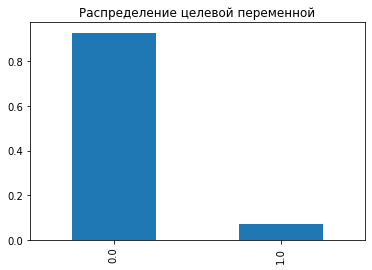

In [96]:
target_distribution(data_train['target'])

>Определили большой дисбаланс классов

#### 1 переменная

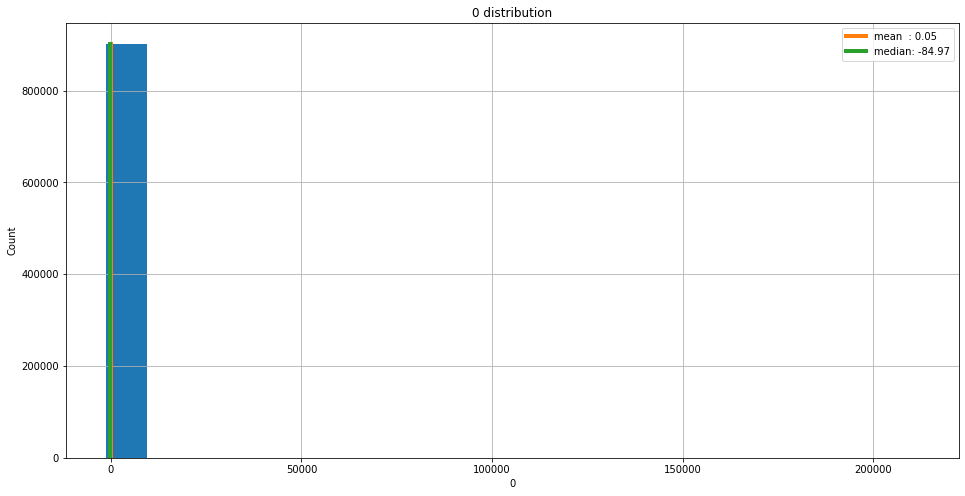

count    902389.000000
mean          0.045011
std         291.888648
min       -1151.889971
25%         -96.799971
50%         -84.969971
75%          11.690029
max      211730.720029
Name: 0, dtype: float64


In [77]:
first_look(features_new['0'], bins=20, is_show_stat=True)

> переменная имеет значительный выброс, посмотрим на 99 квантиль

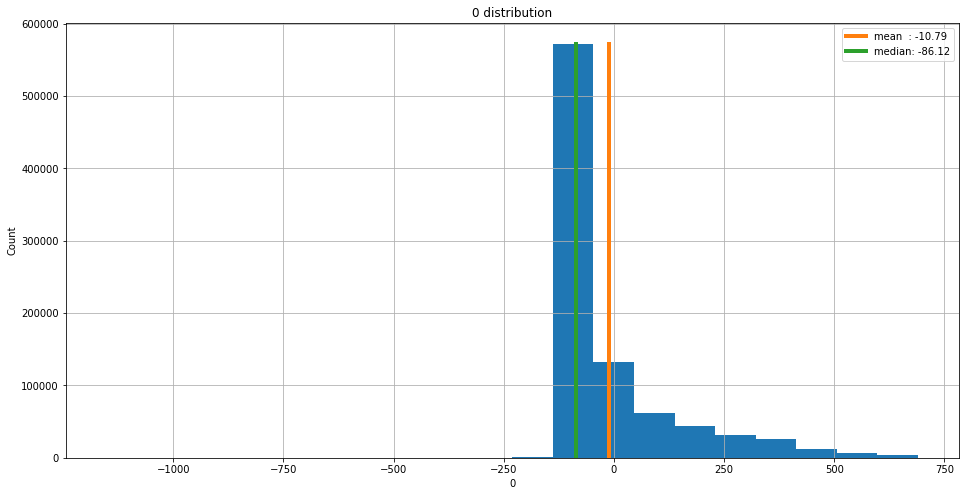

count    892930.000000
mean        -10.788923
std         144.413331
min       -1151.889971
25%         -96.799971
50%         -86.119971
75%           7.000029
max         690.030029
Name: 0, dtype: float64


In [78]:
first_look(features_new['0'], bins=20, is_show_stat=True, quan=0.99, is_correct_outlier=True)

> 10 тыс записей значительно откорректировали распределение переменной

In [ ]:
features_new[features_new['0']>20000]

In [42]:
features_new['0'].quantile(q=0.999)

1598.1200292253036

#### 2 переменная

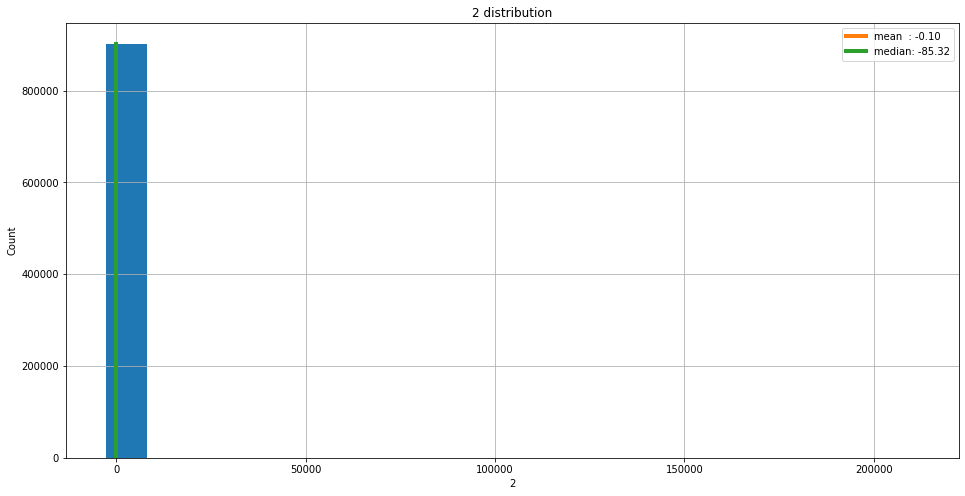

count    902389.000000
mean         -0.097768
std         298.669329
min       -2651.840786
25%        -110.740786
50%         -85.320786
75%          27.199214
max      211716.779214
Name: 2, dtype: float64


In [97]:
first_look(features_new['2'], bins=20, is_show_stat=True)

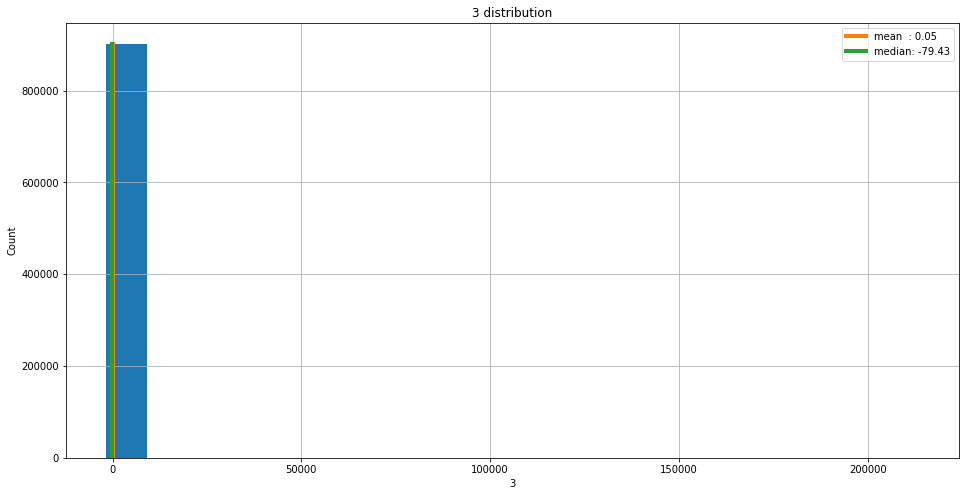

count    902389.000000
mean          0.054796
std         546.362530
min       -1634.436798
25%        -243.156798
50%         -79.426798
75%         126.073202
max      213357.743202
Name: 3, dtype: float64


In [98]:
first_look(features_new['3'], bins=20, is_show_stat=True)

### Соединение наборов данных

Проверим повторы смены профиля на одного пользователя

In [103]:
features_new.index.value_counts().sort_values(ascending=False).head(3)

3549398    2
3353035    2
2926704    2
Name: id, dtype: int64

Проверим частоты приобретения услуг одним клиентом

In [104]:
data_train.index.value_counts().sort_values(ascending=False).head(3)

1347260    3
17679      3
340716     3
Name: id, dtype: int64

In [112]:
data_train.head(3)

,vas_id,buy_time,target
id,,,
540968,8.0,2018-09-17,0.0
1454121,4.0,2018-07-16,0.0
2458816,1.0,2018-08-13,0.0


In [113]:
features_new.head(3)

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2046132,2018-08-20,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
2050810,2018-10-29,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2070757,2018-10-29,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0


In [115]:
features_new[features_new.index == 340716]

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
340716,2018-07-23,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-976.373846,-612.770792,-25.996269,-37.630448,-282.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [116]:
data_train[data_train.index == 340716]

,vas_id,buy_time,target
id,,,
340716,2.0,2018-11-05,0.0
340716,4.0,2018-11-19,1.0
340716,6.0,2018-11-19,1.0


In [132]:
feat_35=features_new[features_new.index == 3549398][['buy_time','1','2','3']]
feat_35

,buy_time,1,2,3
id,,,,
3549398,2018-12-10,588.840888,426.489214,565.063202
3549398,2018-12-17,727.590888,185.129214,708.903202


In [133]:
data_35=data_train[data_train.index == 3549398]
data_35

,vas_id,buy_time,target
id,,,
3549398,2.0,2018-12-17,0.0
3549398,4.0,2018-11-19,1.0


In [134]:
pd.merge(data_35,feat_35,how='outer',on='id')

,vas_id,buy_time_x,target,buy_time_y,1,2,3
id,,,,,,,
3549398,2.0,2018-12-17,0.0,2018-12-10,588.840888,426.489214,565.063202
3549398,2.0,2018-12-17,0.0,2018-12-17,727.590888,185.129214,708.903202
3549398,4.0,2018-11-19,1.0,2018-12-10,588.840888,426.489214,565.063202
3549398,4.0,2018-11-19,1.0,2018-12-17,727.590888,185.129214,708.903202
